In [3]:
from huggingface_hub import notebook_login
from PIL import Image
from datasets import load_dataset

notebook_login()

https://huggingface.co/docs/transformers/en/tasks/image_classification#image-classification

https://huggingface.co/docs/datasets/en/image_dataset

## Converting all images to jpg, and also renaming for simplicity

Converting images with broken label to png first, then converting healthy and storing them in different folders so that they can be labeled in metadata.csv

In [7]:
fp = '../classification_dataset/Cable'


import os
files = os.listdir(f'{fp}/damaged_cord/')

files
ct = 1
for i in files:
    im = Image.open(f'{fp}/damaged_cord/{i}').convert("RGB")
    im.save(f"{fp}/damaged_cord_conv/broken{ct}.png", "png")
    ct+=1

In [10]:

files = os.listdir(f'{fp}/healthy_cord/')

files
ct = 1
for i in files:
    im = Image.open(f'{fp}/healthy_cord/{i}').convert("RGB")
    im.save(f"{fp}/healthy_cord_conv/healthy{ct}.png", "png")
    ct+=1

In [11]:
import csv
healthy = os.listdir(f'{fp}/healthy_cord_conv/')
broken = os.listdir(f'{fp}/damaged_cord_conv/')
#with open('screen_metadata.csv', newline='') as csvfile:
f = open('cord_metadata.csv','w')
    #csvfile.write('file_name,broken')
f.write('file_name,label')
f.write('\n')
for img in healthy:
        f.write(f'{img}, 0')
        f.write('\n')
for img in broken:
        f.write(f'{img}, 1')
        f.write('\n')
f.close()


In [ ]:
dataset = load_dataset("imagefolder", data_dir=f"{fp}/cord_dataset")

Resolving data files:   0%|          | 0/47 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
dataset_identifier = 'charging-cord-classification-dataset'

In [40]:
dataset.push_to_hub(f'dskong07/{dataset_identifier}')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/dskong07/charging-cord-classification-dataset/commit/41655a7959b894c698a9b052be22522add3dd7e6', commit_message='Upload dataset', commit_description='', oid='41655a7959b894c698a9b052be22522add3dd7e6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/dskong07/charging-cord-classification-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='dskong07/charging-cord-classification-dataset'), pr_revision=None, pr_num=None)

## Now getting from HF repo and stuff

In [6]:
cords = load_dataset(f"dskong07/{dataset_identifier}")

In [14]:
cords = cords.shuffle(seed=1)
ds = cords["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

In [15]:
# images labeled with 0 in the dataset are healthy images, and 1 are broken.
id2label={0:'healthy',1:'broken'}
label2id = {v: k for k, v in id2label.items()}

In [16]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"

image_processor = AutoImageProcessor.from_pretrained(checkpoint, use_fast=True)

In [17]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (

    image_processor.size["shortest_edge"]

    if "shortest_edge" in image_processor.size

    else (image_processor.size["height"], image_processor.size["width"])

)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [18]:
def transforms(examples):

    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]

    del examples["image"]

    return examples

In [19]:
ds = ds.with_transform(transforms)

In [20]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [21]:
import evaluate

accuracy = evaluate.load("accuracy")

import numpy as np


def compute_metrics(eval_pred):

    predictions, labels = eval_pred

    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

In [22]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer



model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args = TrainingArguments(
    output_dir="cord-classif-model",
    remove_unused_columns=False,
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=2,
    num_train_epochs=8,
    #warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)


In [24]:

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: dskong07 (dskong07-uc-san-diego) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss,Accuracy
1,0.704200,0.687052,0.500000
2,0.705800,0.674982,0.600000
3,0.641600,0.666744,0.900000
4,0.693600,0.634275,0.700000
5,0.662900,0.619002,0.900000
6,0.719500,0.594652,0.900000
7,0.686800,0.615475,0.900000
8,0.647600,0.553958,0.900000
9,0.755200,0.593123,0.900000
10,0.516800,0.569435,0.900000


Could not locate the best model at cord-classif-model\checkpoint-42\pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=72, training_loss=0.3291759362651242, metrics={'train_runtime': 236.0365, 'train_samples_per_second': 1.22, 'train_steps_per_second': 0.305, 'total_flos': 2.2317693009002496e+16, 'train_loss': 0.3291759362651242, 'epoch': 8.0})

In [25]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/dskong07/cord-classif-model/commit/64a7b7d1e88aabeb18f03dadfd9912770c0edbd1', commit_message='End of training', commit_description='', oid='64a7b7d1e88aabeb18f03dadfd9912770c0edbd1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dskong07/cord-classif-model', endpoint='https://huggingface.co', repo_type='model', repo_id='dskong07/cord-classif-model'), pr_revision=None, pr_num=None)

# Testing model inference from HF api

In [33]:
from transformers import pipeline

classifier = pipeline("image-classification", model="dskong07/cord-classif-model")


#classifier(image)

Device set to use cpu


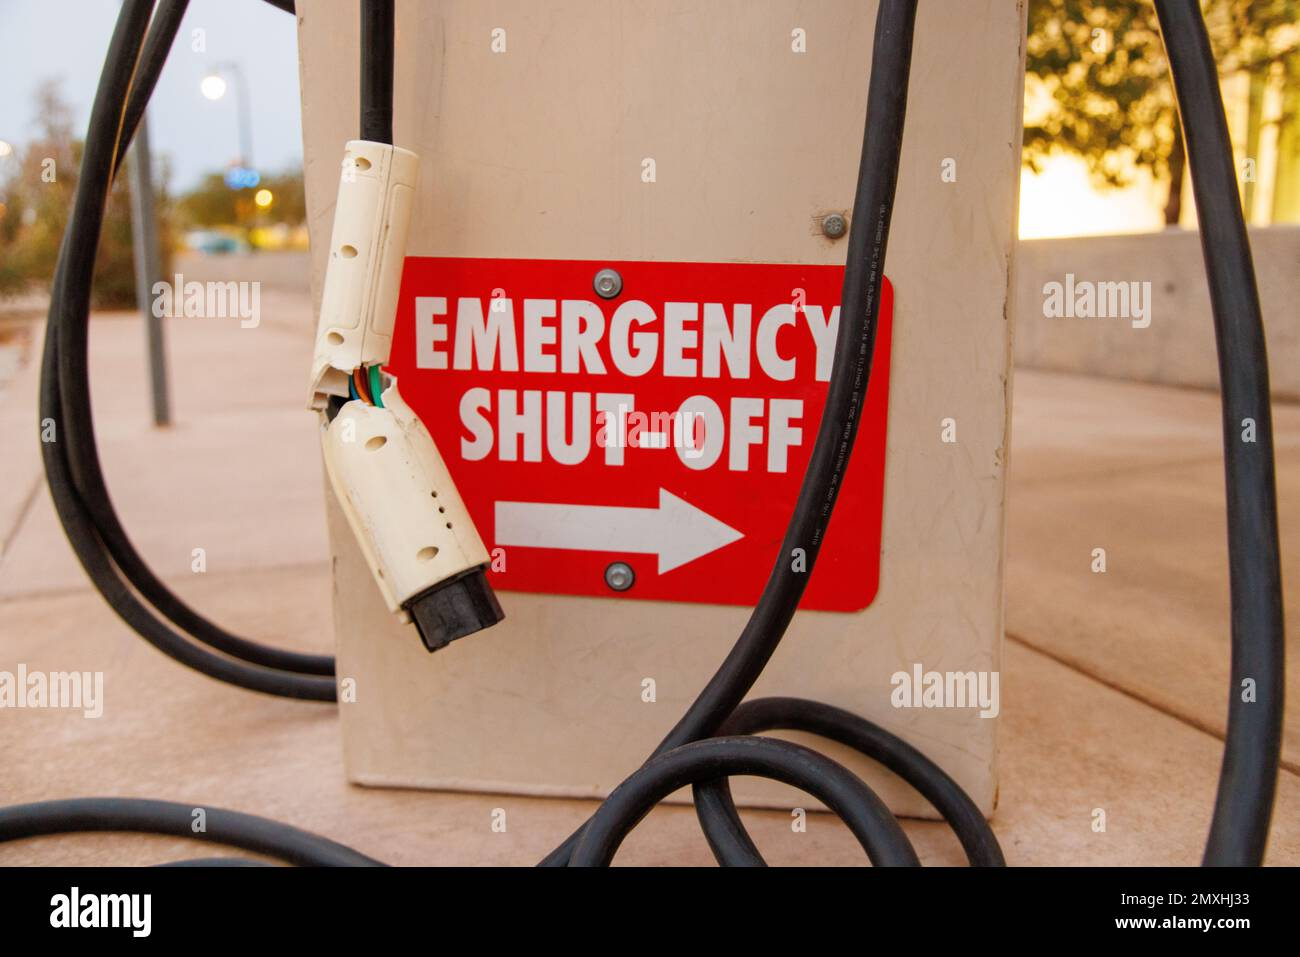

In [34]:
img_test = cords['train']['image'][0]
img_test

In [35]:
classifier(img_test)

[{'label': 'broken', 'score': 0.7805830836296082},
 {'label': 'healthy', 'score': 0.23214012384414673}]

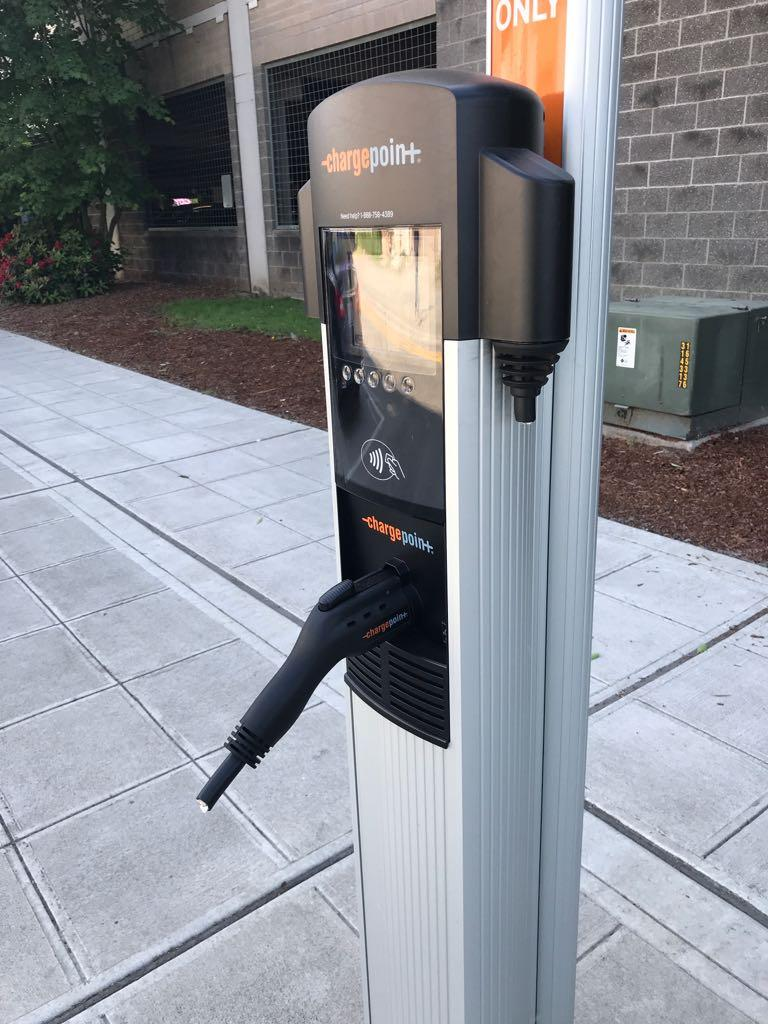

In [36]:
local_img = Image.open(fp='example_data/brokencord_example.png')
local_img

In [37]:
classifier(local_img)

[{'label': 'broken', 'score': 0.8162931799888611},
 {'label': 'healthy', 'score': 0.2257808893918991}]